In [74]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import requests
import numpy as np

In [80]:
class Replaybuffer:
    def __init__(self,n_state,n_action, batchsize):
        self.n_state = n_state
        self.n_action = n_action
        self.size = 2000 #记忆池大小
        self.batchsize = batchsize

        #给记忆五元组申请空间
        self.s = np.empty(shape = (self.size, self.n_state), dtype=np.float32)
        self.a = np.random.randint(low=0, high=n_action, size=self.size, dtype=np.uint8)
        self.r = np.empty(self.size, dtype=np.float32)
        self.done = np.random.randint(low=0, high=2, size=self.size, dtype=np.uint8)
        self.s_ = np.empty(shape = (self.size, self.n_state), dtype=np.float32)

        self.t = 0
        self.tmax = 0  # 初始化tmax属性 ##后加

    def add_memo(self,s,a,r,done,s_): #需要实现功能：1.交互后增加记忆 2.sample batch时取出记忆
    #第t步向记忆池里加记忆
        #print("s:", s.shape)  # 打印s的形状
        #print("Expected s shape:", (self.n_state,))
        self.s[self.t] = s
        self.a[self.t] = a
        self.r[self.t] = r
        self.done[self.t] = done
        self.s_[self.t] = s_
        self.t = self.t + 1 if self.t + 1 < self.size else 1 #t到2001时，重新从1开始加
        self.tmax = max(self.tmax, self.t +1)



    def sample(self):
    #采样逻辑：Buffer里的经验如果比batchsize多，那就sample;如果比batchsize少，那就有几个取几个
        '''if self.tmax > self.size:
            idxes = random.sample(range(0, self.tmax),self.size)
        else:
            idxes = random.sample(range(0, self.tmax))'''

        if self.tmax > self.batchsize:
           k = self.batchsize  # 如果缓冲区样本数大于等于批次大小，使用批次大小
        else:
           k = self.tmax  # 否则，使用缓冲区的实际样本数量

        idxes = random.sample(range(0, self.tmax), k)  # 使用确定的k值抽样

        batch_s = []
        batch_a = []
        batch_r = []
        batch_done = []
        batch_s_ = []

        for idx in idxes: #抽64个数据
            batch_s.append(self.s[idx])
            batch_a.append(self.a[idx])
            batch_r.append(self.r[idx])
            batch_done.append(self.done[idx])
            batch_s_.append(self.s_[idx])

        #把numpy转换成torch的tensor
        batch_s = torch.as_tensor(np.asarray(batch_s),dtype=torch.float32)
        batch_a = torch.as_tensor(np.asarray(batch_a),dtype=torch.int64).unsqueeze(-1) #升维：从(2)升到(2,1)
        batch_r = torch.as_tensor(np.asarray(batch_r),dtype=torch.float32).unsqueeze(-1)
        batch_done = torch.as_tensor(np.asarray(batch_done),dtype=torch.float32).unsqueeze(-1)
        batch_s_ = torch.as_tensor(np.asarray(batch_s_),dtype=torch.float32)

        return batch_s, batch_a, batch_r, batch_done, batch_s_

In [81]:
class Qnetwork(nn.Module):
      def __init__(self, n_input, n_output):
          super().__init__() #继承Module父类

          self.net = nn.Sequential(
              nn.Linear(in_features= n_input, out_features = 128),
              nn.ReLU(), #nn.Tanh(),
              nn.Linear(in_features= 128, out_features = n_output))

      def forward(self,x):
           return self.net(x) #前向传播

      def act(self,obs): #面对s，找到最大的Q值（因为神经网络输出的不只是最大Q值），输出对应的action
          obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
          q_value = self(obs_tensor.unsqueeze(0)) #转化成行向量
          max_q_idx = torch.argmax(input=q_value)
          action = max_q_idx.detach().item() #最大Q值索引对应的action
          return action


class AgentwRB:
   def __init__(self, n_input, n_output,  batchsize, Gamma=0.97, learning_rate = 0.01):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma
            self.batchsize = batchsize
            self.memo = Replaybuffer(self.n_input, self.n_output, self.batchsize) #先实例化Agent，得到memo，Memo再实例化Replaybuffer

            #两个网络结构相同，可以用同一个类实例化
            self.online_net = Qnetwork(self.n_input, self.n_output)
            self.target_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),lr=self.learning_rate)

In [82]:
##BATCH SIZE 5
env = gym.make('CartPole-v1')
n_input = env.observation_space.shape[0]
n_output = env.action_space.n

epsilon_decay = 10000
epsilon_start = 1.0 #best value from tuning hyperparameters
epsilon_end = 0.1
n_step = 500
n_episode = 1000
TARGET_UPDATE = 10
Gamma=0.97
learning_rate = 0.01
s = env.reset()
agent = AgentwRB(n_input, n_output, 5)
episode_array = []
rewards_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end]) #插值
        #episode * n_step + step:当前第episode第step要插值的点
        #[0, EPSILON_DECAY]：数据点横坐标 [EPSILON_START, EPSILON_END]：数据点纵坐标
        #epsilon值会在EPSILON_DECAY之内从EPSILON_START线性变化到EPSILON_END

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode_array.append(episode)
        rewards_array.append(reward)





/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode:0
Reward:nan
Episode:10
Reward:14.9
Episode:20
Reward:12.1
Episode:30
Reward:10.2
Episode:40
Reward:11.6
Episode:50
Reward:13.1
Episode:60
Reward:13.9
Episode:70
Reward:14.5
Episode:80
Reward:27.7
Episode:90
Reward:20.1
Episode:100
Reward:36.1
Episode:110
Reward:29.2
Episode:120
Reward:29.0
Episode:130
Reward:35.3
Episode:140
Reward:23.8
Episode:150
Reward:30.4
Episode:160
Reward:29.9
Episode:170
Reward:82.3
Episode:180
Reward:181.0
Episode:190
Reward:93.5
Episode:200
Reward:56.3
Episode:210
Reward:23.7
Episode:220
Reward:47.5
Episode:230
Reward:57.2
Episode:240
Reward:80.9
Episode:250
Reward:126.3
Episode:260
Reward:72.2
Episode:270
Reward:21.6
Episode:280
Reward:35.8
Episode:290
Reward:66.4
Episode:300
Reward:59.3
Episode:310
Reward:51.0
Episode:320
Reward:18.9
Episode:330
Reward:16.7
Episode:340
Reward:16.5
Episode:350
Reward:19.1
Episode:360
Reward:16.6
Episode:370
Reward:29.5
Episode:380
Reward:17.9
Episode:390
Reward:23.9
Episode:400
Reward:24.8
Episode:410
Reward:50.7
Ep

In [83]:
##BATCH SIZE 10

s = env.reset()
agent = AgentwRB(n_input, n_output, 10)
episode2_array = []
rewards2_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode2_array.append(episode)
        rewards2_array.append(reward)


Episode:0
Reward:nan
Episode:10
Reward:25.0
Episode:20
Reward:15.4
Episode:30
Reward:12.2
Episode:40
Reward:13.8
Episode:50
Reward:21.8
Episode:60
Reward:12.9
Episode:70
Reward:49.8
Episode:80
Reward:51.6
Episode:90
Reward:74.3
Episode:100
Reward:144.4
Episode:110
Reward:293.2
Episode:120
Reward:149.8
Episode:130
Reward:174.9
Episode:140
Reward:67.4
Episode:150
Reward:67.9
Episode:160
Reward:109.8
Episode:170
Reward:115.9
Episode:180
Reward:176.4
Episode:190
Reward:407.5
Episode:200
Reward:78.5
Episode:210
Reward:62.5
Episode:220
Reward:301.9
Episode:230
Reward:193.4
Episode:240
Reward:213.4
Episode:250
Reward:117.3
Episode:260
Reward:114.2
Episode:270
Reward:128.8
Episode:280
Reward:100.7
Episode:290
Reward:94.0
Episode:300
Reward:97.3
Episode:310
Reward:135.6
Episode:320
Reward:131.3
Episode:330
Reward:102.6
Episode:340
Reward:89.7
Episode:350
Reward:180.4
Episode:360
Reward:154.6
Episode:370
Reward:148.4
Episode:380
Reward:121.3
Episode:390
Reward:98.9
Episode:400
Reward:99.7
Episod

In [85]:
##BATCH SIZE 32

s = env.reset()
agent = AgentwRB(n_input, n_output, 32)
episode3_array = []
rewards3_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode3_array.append(episode)
        rewards3_array.append(reward)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode:0
Reward:nan
Episode:10
Reward:15.9
Episode:20
Reward:12.2
Episode:30
Reward:10.8
Episode:40
Reward:12.7
Episode:50
Reward:15.9
Episode:60
Reward:24.4
Episode:70
Reward:41.8
Episode:80
Reward:35.0
Episode:90
Reward:32.1
Episode:100
Reward:17.1
Episode:110
Reward:51.6
Episode:120
Reward:68.6
Episode:130
Reward:76.8
Episode:140
Reward:79.8
Episode:150
Reward:74.0
Episode:160
Reward:82.8
Episode:170
Reward:98.0
Episode:180
Reward:145.9
Episode:190
Reward:51.2
Episode:200
Reward:37.1
Episode:210
Reward:22.7
Episode:220
Reward:89.9
Episode:230
Reward:54.4
Episode:240
Reward:82.1
Episode:250
Reward:31.6
Episode:260
Reward:101.5
Episode:270
Reward:117.7
Episode:280
Reward:22.3
Episode:290
Reward:178.2
Episode:300
Reward:86.4
Episode:310
Reward:30.6
Episode:320
Reward:45.2
Episode:330
Reward:90.8
Episode:340
Reward:97.2
Episode:350
Reward:87.3
Episode:360
Reward:27.4
Episode:370
Reward:32.9
Episode:380
Reward:78.1
Episode:390
Reward:165.4
Episode:400
Reward:160.6
Episode:410
Reward:87.

In [86]:
##BATCH SIZE 64

s = env.reset()
agent = AgentwRB(n_input, n_output, 64)
episode4_array = []
rewards4_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode4_array.append(episode)
        rewards4_array.append(reward)

Episode:0
Reward:nan
Episode:10
Reward:19.6
Episode:20
Reward:20.6
Episode:30
Reward:26.9
Episode:40
Reward:23.9
Episode:50
Reward:45.6
Episode:60
Reward:41.0
Episode:70
Reward:57.5
Episode:80
Reward:80.5
Episode:90
Reward:144.6
Episode:100
Reward:231.4
Episode:110
Reward:142.5
Episode:120
Reward:212.3
Episode:130
Reward:131.9
Episode:140
Reward:138.9
Episode:150
Reward:247.4
Episode:160
Reward:213.2
Episode:170
Reward:101.8
Episode:180
Reward:16.6
Episode:190
Reward:48.1
Episode:200
Reward:83.3
Episode:210
Reward:103.6
Episode:220
Reward:161.8
Episode:230
Reward:119.9
Episode:240
Reward:222.9
Episode:250
Reward:196.8
Episode:260
Reward:211.3
Episode:270
Reward:137.7
Episode:280
Reward:136.0
Episode:290
Reward:145.8
Episode:300
Reward:117.2
Episode:310
Reward:103.7
Episode:320
Reward:92.2
Episode:330
Reward:120.2
Episode:340
Reward:119.9
Episode:350
Reward:94.2
Episode:360
Reward:88.4
Episode:370
Reward:83.1
Episode:380
Reward:83.5
Episode:390
Reward:99.6
Episode:400
Reward:94.8
Episod

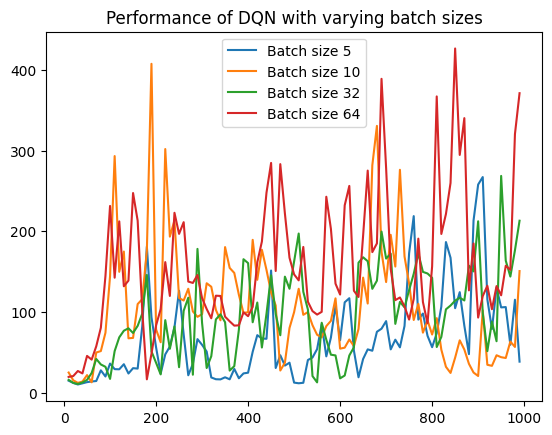

In [87]:
plt.title("Performance of DQN with varying batch sizes")
plt.plot(episode_array, rewards_array, label = "Batch size 5")
plt.plot(episode2_array, rewards2_array, label = "Batch size 10")
plt.plot(episode3_array, rewards3_array, label = "Batch size 32")
plt.plot(episode4_array, rewards4_array, label = "Batch size 64")

plt.legend()
plt.show()